# Home Assigment 2, CMPE 252, Section 02, FALL 2022.

## Question 1: MDP - exact solution in the tabular case. 
In this question you will solve MDP by **Value Iteration** and **Policy Iteration** algorithms with a known dynamics and reward $T$ and $R$, respectively. 

You can work in teams, and discuss your solutions, but not to share your code between the teams.

What to submit in Canvas: a working notebook with the full solution, and its corresponding PDF. 

Due: Oct 17, 11:59PM

import the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

As per the problem definition, we define the following variables:

In [2]:
def build_maze(maze_file):
    '''
    para1: filename of the maze txt file
    return mazes as a numpy array walls: 0 - no wall, 1 - horizontal wall no the bottom of the cell, 2 - vertical wall on the right of the cell
    '''
    a = open(maze_file, 'r')  
    m=[]
    for i in a.readlines():
        m.append(np.array(i.split(" "), dtype="int32"))
    return np.array(m)

#### Use your maze from HW1. Verify that there are multiple paths (at least 3) from the START = 'top left corner' to GOAL='bottom right corner'. If you do not have at least 3 paths, update your maze accordingly

In [3]:
# State Space
S=build_maze('HW2_maze.txt')
START = (1,1)
GOAL = (26,26)
# Action Space
A = [
    (-1, 0),    # 'up'
    (1, 0),     # 'down'
    (0, -1),    # 'left'
    (0, 1),     # 'right'
    (0, 0)      # 'stay'
]


# Noise
ALPHA = [0.2, 0.8]
vs = {}
V_ = []
v_imp = {}
delta_append = []

Define maze. 0 - no wall, 1 - horizontal wall no the bottom of the cell, 2 - vertical wall on the right of the cell

In [4]:

GRID_SIZE = len(S)
# goal state
S[GOAL]    = 3

Visualize the maze

In [5]:
print(S)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 0 2 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 1 1 1 1 1 0 2 0 2 0 1 0 2 0 1 1 1 1 1 0 1 1 1 1 1]
 [1 0 0 0 2 0 2 0 2 0 0 0 2 0 0 0 2 0 0 0 2 0 0 0 0 0 1]
 [1 1 1 0 2 0 2 0 2 1 1 0 2 1 1 1 2 0 1 0 2 1 1 1 1 0 1]
 [1 0 0 0 2 0 2 0 0 0 2 0 2 0 0 0 2 0 2 0 0 0 0 0 0 0 1]
 [1 0 1 1 2 0 2 1 1 0 2 0 2 0 1 0 2 0 2 1 1 1 1 1 1 0 1]
 [1 0 2 0 0 0 2 0 0 0 0 0 0 0 2 0 2 0 2 0 0 0 2 0 0 0 1]
 [1 0 2 1 2 0 2 0 1 1 1 1 1 1 2 0 2 0 2 0 1 1 2 0 1 1 1]
 [1 0 0 0 2 0 2 0 0 0 2 0 0 0 2 0 2 0 2 0 0 0 0 0 0 0 1]
 [1 1 1 0 2 0 2 1 1 0 2 1 1 0 2 0 2 0 2 1 1 1 1 1 1 1 1]
 [1 0 0 0 2 0 0 0 2 0 0 0 2 0 2 0 2 0 0 0 0 0 2 0 0 0 1]
 [1 0 1 1 2 0 1 0 2 1 1 0 2 0 2 0 2 1 1 1 1 0 2 0 1 0 1]
 [1 0 2 0 0 0 2 0 0 0 2 0 2 0 0 0 0 0 2 0 2 0 2 0 2 0 1]
 [1 0 2 1 1 1 2 1 1 0 2 0 2 1 1 1 1 0 2 0 2 0 2 0 2 0 1]
 [1 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 2 0 0 0 2 0 2 0 2 0 1]
 [1 0 1 1 1 1 1 1 1 0 2 0 2 0 1 0 2 1 1 0 2 0 2 0 2 0 1]
 [1 0 0 0 2 0 2 0 0 0 2 0 0 0 2

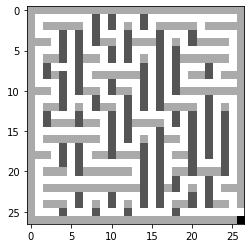

In [6]:
plt.imshow(S, cmap='binary')

We will define a utility function s_next_calc which computes the index of the next state given current state and action.

In [7]:
def s_next_calc(s, a):
    '''This function returns the agent's next state given action
    and current state (assuming the action succeeds).
    : param s: Current position of the agent
    : param a: action taken by the agent
    : returns: New state coordinates in the grid
    '''
    
    return (s[0] + A[a][0], s[1] + A[a][1])

A Utility function to check if the action at current state leads to a collision with a wall.

In [8]:
def hit_wall(curr, action):
    '''This function checks if the agent hits any walls.
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: True/False Binary value to indicate if agent hits a wall
    '''
    s_new = (
        curr[0] + A[action][0],
        curr[1] + A[action][1]
    )

    # Check for grid boundaries
    if min(s_new) < 0 or max(s_new) > GRID_SIZE-1:
        return True

    # Check walls
    # 0: 'up':   (-1,  0),
    # 1: 'down': ( 1,  0),
    # 2: 'left': ( 0, -1),
    # 3: 'right':( 0,  1),
    # 4: 'stay': ( 0,  0)
    if (S[curr]==1 and action==1) \
        or (S[curr]==2 and action==3) \
        or (S[s_new]==1 and action==0)\
        or (S[s_new]==2 and action==2):
        return True

    return False

Reward function.

In [9]:
def R(s, a):
    '''Reward function
    : param s: Current state of the agent
    : param a: Action the agent takes at the current state
    : returns: Reward for the action at current state
    '''
    if s == GOAL:
        return 0
    elif hit_wall(s, a):
        return -10000
    else:
        return -1

In [ ]:
red_factor = 0.8  #initial assumption

Calculate the transition probabilities to state s_next from current state s upon action a.

In [10]:
def Pr(s_next, s, a, alpha):
    '''This function returns probabilities for each action at agent's
    current state.
    :param s: Current state of the agent
    :param a: Action the agent takes at the current state
    :param alpha: Probability of the agent to take a random action instead of the action a
    :returns : Transition probability for the action at current state
    '''
    # can't move once reached the GOAL
    if s == GOAL:
        if s_next == s:
            return 1
        else:
            return 0

    # If wall hit, next state is current state
    if hit_wall(s, a):
        # Illegal action with s = s'
        if s_next == s:
            return 1
        # Illegal action with s != s'
        else:
            return 0

    # Legal action with adjacent s and s'
    if s_next == s_next_calc(s, a):
        return 1 - alpha
    else:
        # Agent moves to another adjacent state instead of s' due to noise in a
        # Generate all other neighbors of s by applying actions other than a
        other_s_next = [s_next_calc(s, i)
                    for i in range(len(A)) if i is not a]
        if s_next in other_s_next:
            return alpha/4
    return 0

## Policy Iteration

In policy iteration, we define three functions:

* policy_evaluation
* policy_improvement
* policy_iteration

Refer to the lecture slides on policy iteration and value iteration. 

In [11]:
def policy_evaluation(policy, S, Pr, alpha, ctr):
    V = np.zeros((GRID_SIZE, GRID_SIZE))
    for _ in range(ctr):
        #print(_+1)
        delta = 0
        for s, _ in np.ndenumerate(S):
          v=V[s]
          a = policy[s]
          V[s]=R(s,a)+1*sum(Pr(s_n,s,a,alpha)*V[s_n] for s_n,_ in np.ndenumerate(S))
          delta = max(delta, abs(v - V[s]))
    
        if delta < 0.0: break
    #print(delta)

    return V, delta
   

In [12]:
def policy_improvement(V, S, A, Pr, alpha):
    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    policy_stable = True
    for s, _ in np.ndenumerate(S):
        old_action = policy[s]
        Q = np.zeros(len(A))
        for a in range(len(A)):
            # update Q function at state, s, and action, a
            Q[a] =R(s,a)+sum(Pr(s_next,s,a,alpha)*V[s_next] for s_next,_ in np.ndenumerate(S))
            # update policy at state s
            policy[s] =np.argmax(Q)
        if old_action != policy[s]: policy_stable = False
    
    return policy, policy_stable

In [13]:
def policy_iteration(S, A, Pr, alpha, n_eval, plot=None):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function Pr: transition function
    :param float alpha: discount factor
    :param int n_iter: number of iterations
    :param int n_eval: number of evaluations
    :param plot: list of iteration numbers to plot
    """
    plt.ion()
    policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE))
    count=0

    while True:
        #print(count)
        V, delta = policy_evaluation(policy, S, Pr, alpha, n_eval)
        #print(delta)
        policy , policy_stable = policy_improvement(V, S, A, Pr, alpha)
        # plot current value and optimal policy
        if plot and count+1 in plot or delta==0:
            plot_value_grid(V, policy, msg='Policy iteration, alpha = {}, iteration = {}'.format(alpha, count+1))
        if delta<=0 or count==99 or policy_stable:    
            break
        count=count+1

    return V, policy, count

## Value Iteration

We use the following function for value iteration. See slides starting from 161.

In [14]:
def value_iteration(S, A, Pr, alpha, red_factor, plot=None):
    """
    :param list S: set of states
    :param list A: set of actions
    :param function Pr: transition function
    :param float alpha: noise parameter
    """
    plt.ion()

    V = np.zeros((GRID_SIZE, GRID_SIZE))
    optimal_policy = np.random.randint(0, len(A), (GRID_SIZE, GRID_SIZE), dtype=int)

    count=0
    while True:
        delta = 0 
        V_prev=np.copy(V)
        for s,_ in np.ndenumerate(S):
            v = V[s]
            Q = np.zeros(len(A))
            for a in range(len(A)):
                Q[a] = R(s,a)+ red_factor *sum(Pr(s_n,s,a,alpha)*V_prev[s_n] for s_n,_ in np.ndenumerate(S))
            V[s] = max(Q)
            delta = max(delta, abs(v - V[s])) #set the validation condition for the convergence
            print(delta)
            
            optimal_policy[s] = np.argmax(Q)
        
        

        # plot current value and optimal policy
        if plot and count+1 in plot:
            plot_value_grid(V, optimal_policy, msg='Value iteration, alpha = {}, iteration = {}'.format(alpha, count+1))
            plt.pause(0.1)
        if delta <= 0 or count==100: 
             print(count+1, delta)
             plot_value_grid(V, optimal_policy, msg='Value iteration, alpha = {}, iteration = {}'.format(alpha, count+1))
             plt.pause(0.1)
             break
        count=count+1
    return V, optimal_policy, count

We will use the following utility function to plot the grid with values from V.

In [15]:
def plot_value_grid(V, policy, msg=""):
    plt.figure(figsize=(5, 5), tight_layout=True)
    plt.title(msg)
    plt.imshow(V)
    quiver_action_dict = [
            [1, 0],
            [-1, 0],
            [0, -1],
            [0, 1],
            [0, 0]
    ]
    for k, a in np.ndenumerate(policy):
        plt.quiver(k[1], k[0],
                  quiver_action_dict[a][1], quiver_action_dict[a][0])
    plt.show()

## Tasks
### A. Find the optimal solution by two methods for $\alpha$ = 0.

#### I. Policy Iteration 

We are using iterative policy evaluation.

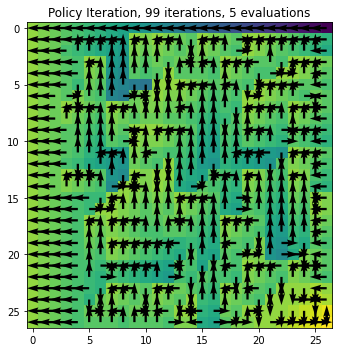

In [ ]:
n_pol_eval = 5 #number of policy evalutions
val2, pol2, pol_max_iter = policy_iteration(S, A, Pr, alpha = 0, n_eval = n_pol_eval)
# Plot for policy iteration alpha = 0, k_max = 100, run for 100 iterations
plot_value_grid(val2, pol2, msg='Policy Iteration, {} iterations, {} evaluations'.format(pol_max_iter, n_pol_eval))
# Plot for value iteration alpha = 0, 100 iterations
# plot_value_grid(val1, pol1, msg='Value Iteration, {} iterations'.format(val_max_iter))

#### II. Value Iteration

Run for 100 iterations and no noise
Plot the value function and the optimal policy every 20 iterations

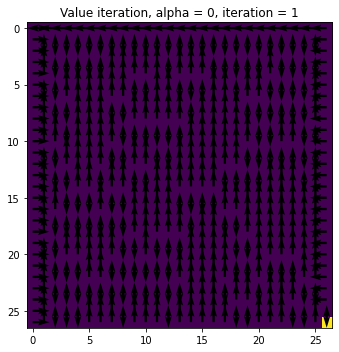

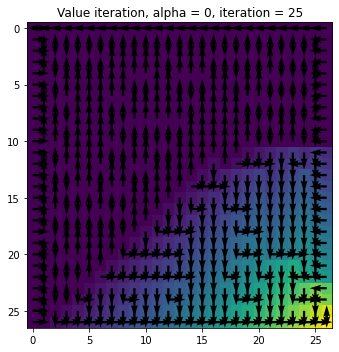

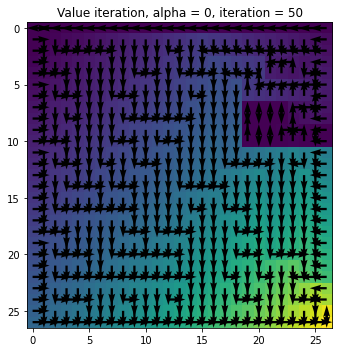

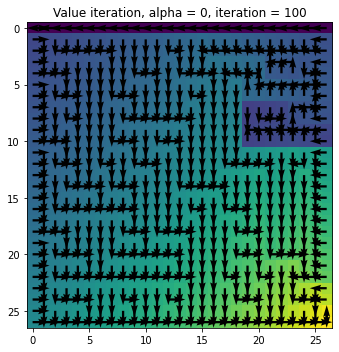

101 0.07951728986183326


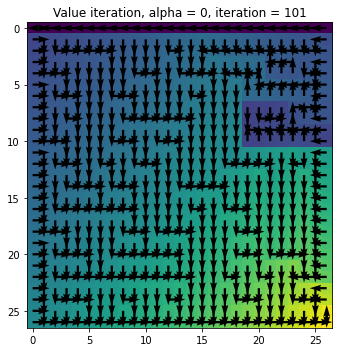

In [ ]:

val1, pol1, val_max_iter = value_iteration(S, A, Pr, alpha=0,  red_factor = 0.8, plot=[1, 25, 50, 100])

Let's visualize these results

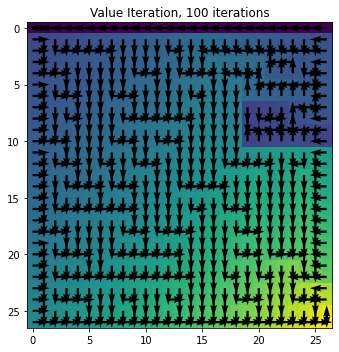

In [ ]:
# Plot for policy iteration alpha = 0, k_max = 100, run for 100 iterations
#plot_value_grid(val2, pol2, msg='Policy Iteration, {} iterations, {} evaluations'.format(pol_max_iter, n_pol_eval))
# Plot for value iteration alpha = 0, 100 iterations
plot_value_grid(val1, pol1, msg='Value Iteration, {} iterations'.format(val_max_iter))

**Note: assure to add title, legends, axis, axis title for the graph which need to be plotted**

### III. Use five different discounted factors $\gamma \in \{0, 0.1, 0.4, 0.9, 1\}$ and preform the following tasks

1. Explain the change in utilities for different $\gamma$
2. Explain the change in optimal policies for different $\gamma$

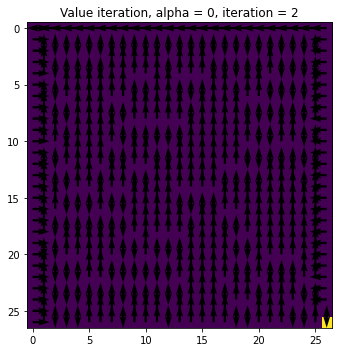

2 0


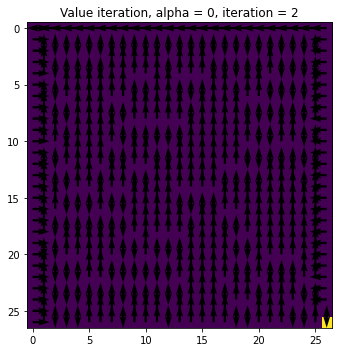

In [ ]:
start_time = time.time()
val1, pol1, val_max_iter = value_iteration(S, A, Pr, alpha=0, red_factor=0, plot=[2])
end_time = time.time()
time1 = end_time - start_time

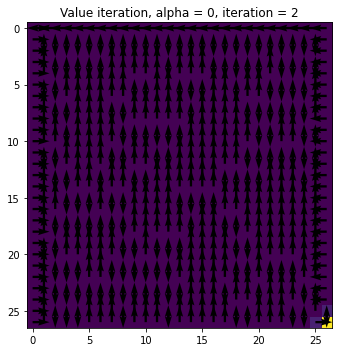

18 0


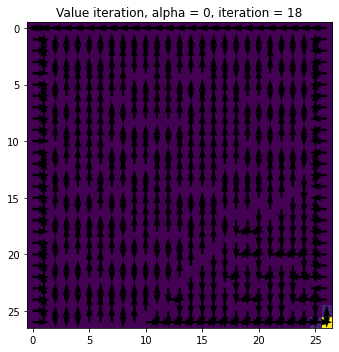

In [ ]:
start_time = time.time()
val1, pol1, val_max_iter = value_iteration(S, A, Pr, alpha=0, red_factor=0.1, plot=[2])
end_time = time.time()
time2 = end_time - start_time

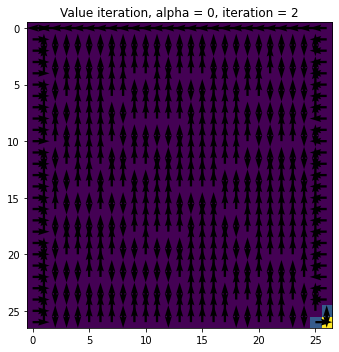

41 0


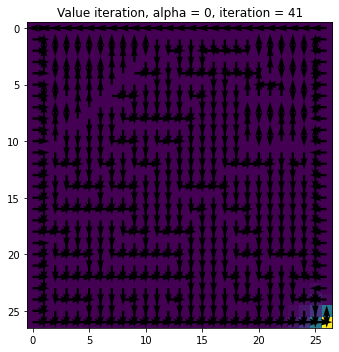

In [ ]:
start_time = time.time()
val1, pol1, val_max_iter = value_iteration(S, A, Pr, alpha=0, red_factor=0.4, plot=[2])
end_time = time.time()
time3 = end_time - start_time

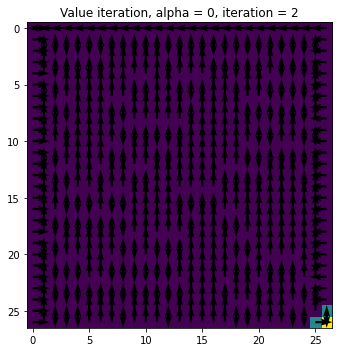

101 2.65613988883473e-05


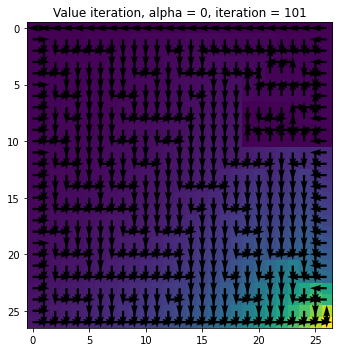

In [ ]:
start_time = time.time()
val1, pol1, val_max_iter = value_iteration(S, A, Pr, alpha=0, red_factor=0.9, plot=[2])
end_time = time.time()
time4 = end_time - start_time

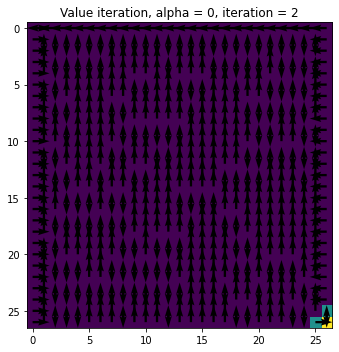

101 1.0


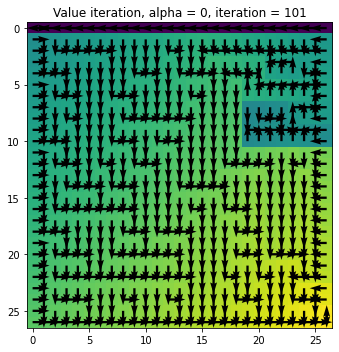

In [ ]:
start_time = time.time()
val1, pol1, val_max_iter = value_iteration(S, A, Pr, alpha=0, red_factor=1, plot=[2])
end_time = time.time()
time5 = end_time - start_time

### IV. Plot $\gamma$ VS computational time for the given $\gamma$ 's in Task 3:

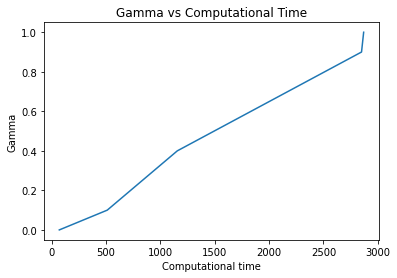

In [ ]:
comp_time = [time1, time2, time3, time4, time5]
gamma = [0,0.1,0.4,0.9,1]
plt.plot(comp_time, gamma)
plt.xlabel('Computational time') 
plt.ylabel('Gamma')
plt.title('Gamma vs Computational Time')
plt.show()

### V. Plot graph which has two line one indicates the sweep in policy in policy evalution and Policy update in policy improvement in each epochs for different $\gamma \in \{0, 0.1, 0.4, 0.9, 1\}$ and also explain insights

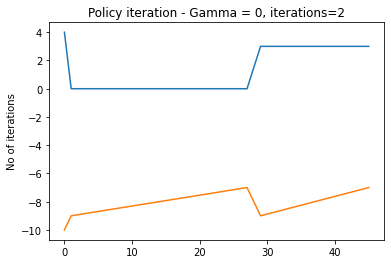

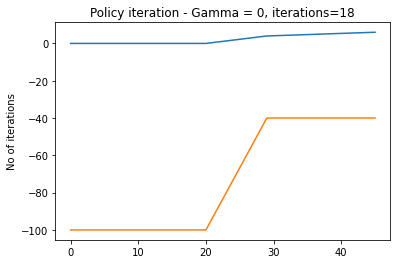

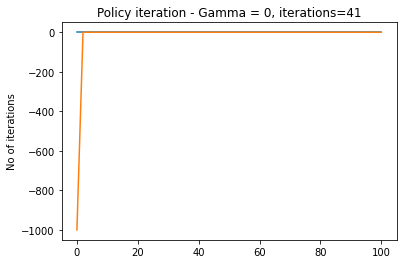

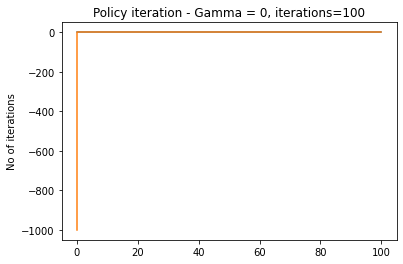

In [ ]:
k = [i+1 for i in range(len(V_))]
plt.figure(figsize=(10, 10)) 
plt.plot( np.array(delta_append), np.array(k))

### VI. plot norm(V_{k+1} - V_k) as a function of k, and explain your observations.
 where k is the iteration in which it converges 

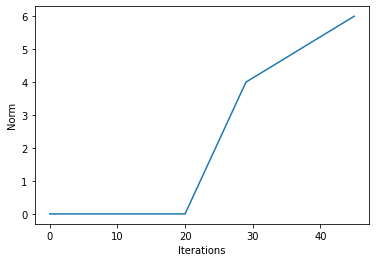

In [ ]:
k = [i+1 for i in range(len(V_))]
plt.figure(figsize=(10, 10)) 
plt.plot( np.array(delta_append), np.array(k))

### VII. Calculate the delta in iteration of the policy iteration for different theta and gamma. Plot them and also Explain your understanding

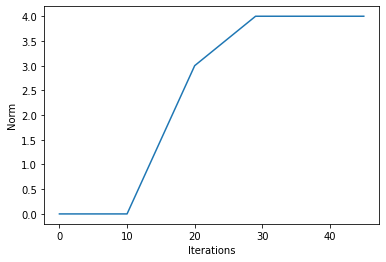

In [ ]:
k = [i+1 for i in range(len(V_))]
plt.figure(figsize=(10, 10)) 
plt.plot( np.array(delta_append), np.array(k))

### B. Repeat Value and Policy iteration for 10, 20 and 100 iterations with $\alpha \in \{0.2, 0.8\}$

#### I. Policy Iteration 

In [ ]:

for idx1, alpha in enumerate(ALPHA):
    #for idx2, i in enumerate():
     val, pol, pol_iter = policy_iteration(S, A, Pr, alpha=alpha, n_eval=100, plot=[10, 20, 100])

#### II. Value Iteration

Streaming output truncated to the last 5000 lines.
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0

/usr/local/lib/python3.7/dist-packages/matplotlib/quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.7/dist-packages/matplotlib/quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


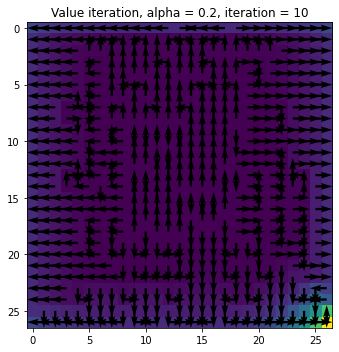

Streaming output truncated to the last 5000 lines.
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.05290402906166136
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.053168695605643634
0.05350591115540304
0.05350591115540304
0.05350591115540304
0.054204190088892545
0.054204

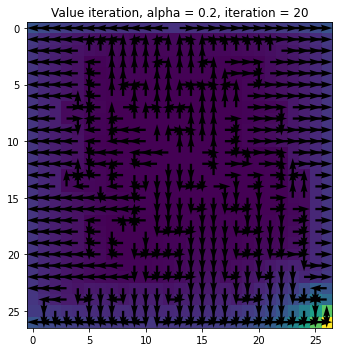

Streaming output truncated to the last 5000 lines.
2.8601121471183433e-11
2.8601121471183433e-11
2.8601121471183433e-11
2.8601121471183433e-11
2.8601121471183433e-11
2.8601121471183433e-11
2.8601121471183433e-11
2.8601121471183433e-11
2.8601121471183433e-11
2.8601121471183433e-11
2.8601121471183433e-11
2.8601121471183433e-11
2.8601121471183433e-11
2.8601121471183433e-11
2.8601121471183433e-11
2.8601121471183433e-11
2.8968827336939285e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912054338027e-11
3.026912

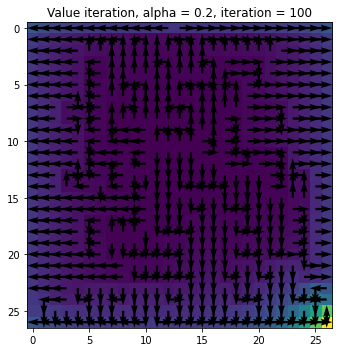

4.134470543704083e-13
4.405364961712621e-13
4.707345624410664e-13
5.018208071305708e-13
5.346834086594754e-13
5.684341886080801e-13
6.057376822354854e-13
6.412648190234904e-13
6.901146321069973e-13
8.029132914089132e-13
9.201528428093297e-13
1.0800249583553523e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.191935439237568e-12
1.3091749906379846e-12
2.467359649926948e-12
2.602362769721367e-12
3.5234037909503968e-12
3.5234037909503968e-12
3.5234037909503968e-12
3.5234037909503968e-12
3.5234037909503968e-12
3.5234037909503968e-12
3.5234037909503968e-12
3

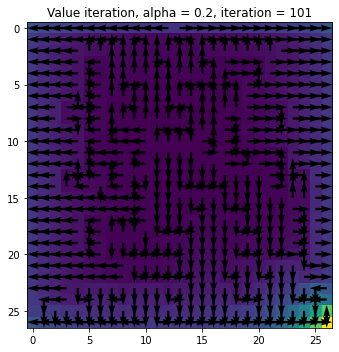

Streaming output truncated to the last 5000 lines.
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0.512
0

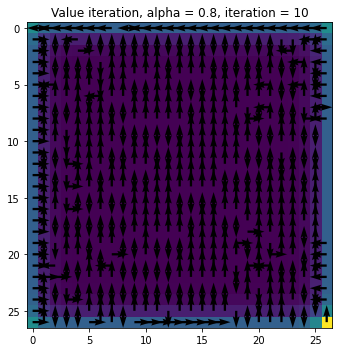

Streaming output truncated to the last 5000 lines.
0.0503424478778669
0.0503424478778669
0.0503424478778669
0.0503424478778669
0.0503424478778669
0.0503424478778669
0.0503424478778669
0.0503424478778669
0.0503424478778669
0.05165176723781428
0.05280339440788673
0.053178204550327735
0.05327677100731165
0.05329735079127751
0.05330067917658088
0.05330108022212965
0.05330111417926986
0.053301115980709746
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05330111602574661
0.05397055521365246
0.05434907488103313
0.05444824027173212
0.05446887801702527
0.054472206402329526
0.05447260744787652
0.05447264140501762
0.054472643206457505
0.05447264325149348
0.05447264325149348
0.054472643251

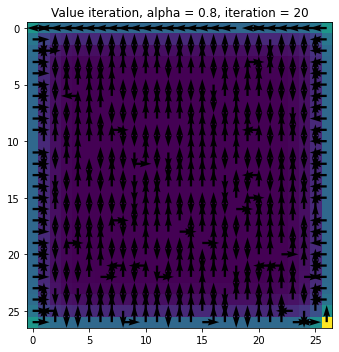

Streaming output truncated to the last 5000 lines.
7.852367645000413e-10
7.852367645000413e-10
7.852367645000413e-10
7.852367645000413e-10
7.852367645000413e-10
7.852367645000413e-10
7.852367645000413e-10
7.852367645000413e-10
7.852367645000413e-10
7.852367645000413e-10
7.852367645000413e-10
7.852367645000413e-10
7.852367645000413e-10
7.852367645000413e-10
7.852367645000413e-10
8.158238529176742e-10
8.40973513049903e-10
8.580620658449334e-10
8.679421625856776e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.711698029628678e-10
8.822489405702072e-10
9.09

KeyboardInterrupt: ignored

In [ ]:
for idx1, alpha in enumerate(ALPHA):
    val, pol, val_iter = value_iteration(S, A, Pr, alpha = alpha, red_factor = 0.8, plot=[10, 20, 100])

**Summarize insights and your observations in Question 1 & 2 .** 

Noise(alpha) determines the quality of output we get. When there is no noise(zero) or less noise(0.2), our functions perform pretty much well. But as noise increases to 0.8, we don't get the desired output. 
Coming to explanations about the functions - 
We have 4 important functions here:
1. policy evaluation
2. policy iteration
3. policy improvement
4. value iteration

policy evaluation - random policy is taken and its effectiveness is assessed by finding its value. This is to know how good the random policy we selected is for finding the path.

policy iteration - this is taking a lot of computational time because each iteration consists of iterations of the policy evaluation as there is a function call regarding the same. 

policy improvement- we create more improvised policies by taking the previous policy into consideration and improve on that.


value iteration - this is much faster compared to policy iteration because we take all states into consideration and compute on all of them collectively. We select a value function and find its state-action function Q, we improve Q based on previous value function and find the optimal value function which will be the maximum of all. Optimal policy here will be the np.argmax(Q).


### C. Explain (up to 5 sentences) the differences between the approaches in HW1 (search, A*) and the approaches in the current assignment (MDP/Value/Policy) 

The first assignment on A* algorithm is based on heuristic approach, wherein we calculate the distance between the start node to the end node via an intermediate node. A* algorithm is better computational wise than Dijkstra and BFS algorithms. But for this assignment, we take into consideration the probability of reaching the goal in shortest path. Probability of policies are considered, the policies are improvised, their values assessed and then, we choose the best of them to move forward.